In [1]:
using Random, PyPlot, LinearAlgebra, Statistics, DataFrames, FITSIO, FITSTables, CSV, PyCall, JLD2

┌ Warning: PyPlot is using tkagg backend, which is known to cause crashes on MacOS (#410); use the MPLBACKEND environment variable to request a different backend.
└ @ PyPlot /Users/aw/.julia/packages/PyPlot/4wzW1/src/init.jl:192


In [2]:
include("get_lamost_spectra.jl")
LogNorm = pyimport("matplotlib.colors").LogNorm
include("../cats/human_readable_names.jl")
include("figures.jl")
include("model.jl")
;

# prep data

In [3]:
wl_grid = load("wl_grid.jld2")["wl_grid"];

In [4]:
Random.seed!(0)
ntest = 1000
test_obsids = rand(FITS(f->DataFrame(f[2]), "../cats/LAMOST-dr5-v3-stellar.fits.gz").obsid, ntest);
download_lamost_spectra(test_obsids);
test_spectra = []
test_ivar = []
for obsid in test_obsids
    wl, flux, ivar = load_lamost_spectrum(obsid)
    push!(test_spectra, flux)
    push!(test_ivar, ivar)
end

;

of 1000 spectra, 0 need to be downloaded


In [5]:
#rf_obsids = CSV.read("./distributed_DR5_1000.csv").obsid;
Random.seed!(12345)
rf_obsids = rand(FITS(f->DataFrame(f[2]), "../cats/LAMOST-dr5-v3-stellar.fits.gz").obsid, 3000);
download_lamost_spectra(rf_obsids)

rf_spectra = []
rf_ivar = []
for obsid in rf_obsids
    wl, flux, ivar = load_lamost_spectrum(obsid)
    push!(rf_spectra, flux)
    push!(rf_ivar, ivar)
end
rf_spectra = transpose(reduce(hcat, rf_spectra))
rf_ivar = transpose(reduce(hcat, rf_ivar))
;

of 3000 spectra, 0 need to be downloaded


In [36]:
#remove blue end of spectrum
#test_spectra = [s[500:end] for s in test_spectra]
#test_ivar = [v[500:end] for v in test_ivar]
#rf_spectra = rf_spectra[:, 500:end]
#;

In [19]:
#whiten spectra
#typical_uncertainty = [mean(col[col .!= 0.0].^(-1/2)) for col in eachcol(rf_ivar)];
#error = [mean(col[col .!= 0.0].^(-1/2)) for col in eachcol(rf_ivar)];
#plot(wl_grid, typical_uncertainty)
#
#rf_spectra .-= 1
#rf_spectra ./= typical_uncertainty'
#rf_ivar .*= typical_uncertainty'.^2
#test_spectra = [(f .- 1)./typical_uncertainty for f in test_spectra]
#test_ivar = [iv .* typical_uncertainty.^2 for iv in test_ivar]
#;

# compare old and new methods

(2999, 2999)
  4.271330 seconds (23 allocations: 275.552 MiB)
[-3.6238167767300543e-12, 1.6969080948074015e-11, 0.5724547450753612, 8.437191216724493, 8.778648130405626, 8.892568165668118, 9.38316596467667, 9.50587847129612, 9.761577455448041, 9.826561243814375, 10.368788066060258, 10.601253467815875, 10.91228530716904, 11.40117147102809, 11.619754931615866, 11.69314146168564, 11.864111612426656, 12.061025506948916, 12.173889864295957, 12.563817262238562, 12.687199569249032, 13.110812328005302, 13.304209745157968, 13.458381688019657, 13.6871095419772, 13.720577552365592, 13.922722434520091, 14.251853453519475, 14.4253974665455, 14.67872977851392, 14.893772567016379, 15.233074559658169, 15.29928517410468, 15.501748382156094, 15.724050380776427, 16.02866340124352, 16.0828686653146, 16.244390891812003, 16.527922273405892, 16.775777965700783, 17.158058416556468, 17.267913071027206, 17.402341559420158, 17.54637128358044, 17.86941624392787, 18.012671584599335, 18.28436252978123, 18.689756887

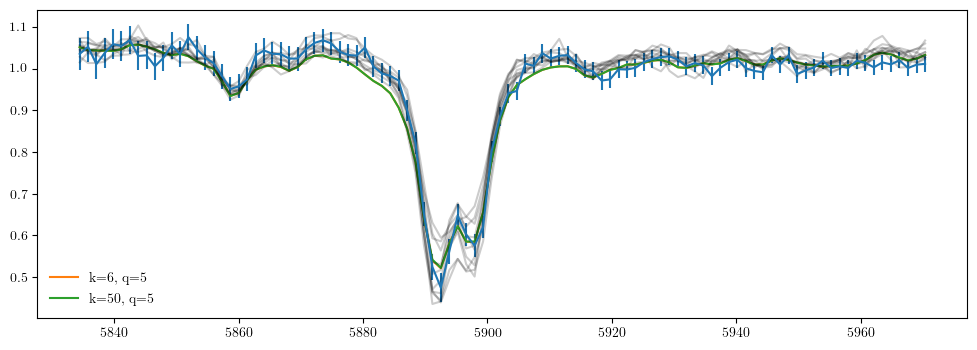

.64937941024, 74227.46144213095, 74869.64895188167, 74948.88783158129, 75693.53411468773, 76128.88158426338, 77105.52801650735, 77438.670663003, 77907.92860271221, 78416.78669958019, 78683.13233101569, 79359.82265650171, 79633.65471838204, 80302.12377902227, 81123.30341652092, 81624.21039371341, 82152.1677097651, 82964.31541112813, 84149.03439592794, 84506.9414584555, 84739.75744459228, 85806.99620545622, 86126.82556675523, 86971.80381453957, 87049.20863504431, 87850.35879282383, 88428.10700268383, 88662.21203063721, 89629.21145793896, 91082.89039723108, 91335.13608222891, 91934.5735068166, 93240.35077658732, 93833.38853519694, 94956.21494982473, 95688.2144426213, 95870.55981745294, 96388.25551603081, 97299.1556442508, 97755.66408708127, 98889.2194603091, 99034.43923454075, 100978.21172818818, 101499.24773993723, 101979.47988211577, 103006.71103819675, 103968.32135723253, 104175.7891718888, 105107.89051273816, 105747.45060577535, 106240.27936505227, 107657.89570306079, 108614.575464632

PyObject <matplotlib.legend.Legend object at 0x148faf470>

In [30]:
include("model.jl")

maskfrac = 0.1
k = 10
q = 5

rf_set = rf_spectra

f, ivar = rand(collect(zip(test_spectra, test_ivar)))
mask = rand(size(rf_spectra, 2)) .< maskfrac


figure(figsize=(12, 4))
pltmask = 1750:1850
errorbar(wl_grid[pltmask], f[pltmask], yerr=ivar[pltmask].^(-1/2))
pf = predict_spectral_range(f, ivar, rf_spectra, rf_ivar.^(-5f-1), 6, 5, mask)
plot(wl_grid[pltmask], pf[pltmask], label="k=6, q=5")
pf = predict_spectral_range(f, ivar, rf_spectra, rf_ivar.^(-5f-1), 50, 5, mask)
plot(wl_grid[pltmask], pf[pltmask], label="k=50, q=5")

σ = ivar.^(-1/2)
σ[σ .== Inf] .= 1.
neighbors = find_neighbors(f[.! mask], σ[.! mask], rf_spectra[:, .! mask]', zeros(size(rf_spectra[:, .! mask]')), k)
plot(wl_grid[pltmask], rf_spectra[neighbors, pltmask]', c="k", alpha=0.2)
legend()

# parameter study

In [7]:
include("model.jl")
function MSE(rf_spectra, test_spectra, test_ivar, k, q; maskfrac = 0.1)
    Random.seed!(2)
    
    MSE = map(collect(zip(test_spectra, test_ivar))) do (f, ivar)
        masksize = 100
        npix = size(rf_spectra, 2)
        ind = rand(1 : npix-100)
        mask = ind .<= (1:npix) .<= ind + 100
        
        pf = predict_spectral_range(f, ivar, rf_spectra, rf_ivar.^(-5f-1), k, q, mask)
        
        #ivar = copy(ivar)
        #σ = ivar.^(-1/2)
        #σ[σ .== Inf] .= 1.
        #
        #neighbors = find_neighbors(f, σ, rf_spectra', zeros(size(rf_ivar')), k)
        #F = rf_spectra[neighbors, :] 
        #error = [mean(col[col .!= 0.0].^(-1/2)) for col in eachcol(rf_ivar[neighbors, :])];
        #pf = project_onto_local_manifold((F .- 1)./error', (f.-1)./error, ivar.*error.^2, mask, q) .* error .+ 1
        #pf = project_onto_local_manifold(F, f, ivar, mask, q)
        
        #figure(figsize=(12, 4))
        #errorbar(wl_grid[mask], f[mask], yerr=ivar[mask].^(-1/2))
        #plot(wl_grid[mask],pf[mask])
        #plot(wl_grid[mask],F[:, mask]', c="k", alpha=0.1)
        #figure(figsize=(12, 3))
        #plot(wl_grid,f)
        #plot(wl_grid,pf)
        #plot(wl_grid,F', c="k", alpha=0.1)
        
        mean((pf[mask] - f[mask]).^2 .* ivar[mask])
    end
    mean(MSE)
end
@time MSE(rf_spectra, test_spectra, test_ivar, 10, 5)

InterruptException: InterruptException:

In [ ]:
### @time for k in 10:30:120
    qs = collect(5:10:k-1)
    MSEs = [MSE(rf_spectra, test_spectra, test_ivar, k, q) for q in qs]
    plot(qs, MSEs, label="k=$k")
end
xlabel("q")
ylabel("MSE")
legend()

In [74]:
any(rf_spectra .== Inf)

false

In [71]:
q = 4
ks = 5:20:100
@time MSEs = map(ks) do k
    MSE(rf_spectra, test_spectra, test_ivar, k, q)
end
plot(ks, MSEs) 
xlabel("k")
ylabel("MSE")

ArgumentError: ArgumentError: matrix contains Infs or NaNs

# test Li outliers with large $k, q$

In [7]:
using CSV
outliers = CSV.read("distributed_topsnr_1000_test.flagged.csv");

In [124]:
download_lamost_spectra(outliers.obsid)

outlier_spectra = []
outlier_ivar = []
for obsid in outliers.obsid
    wl, flux, ivar = load_lamost_spectrum(obsid; clip=false)
    push!(outlier_spectra, flux)
    push!(outlier_ivar, ivar)
end
;

of 760 spectra, 0 need to be downloaded


In [228]:
wl_grid = load("wl_grid.jld2")["wl_grid"]
Δλ = 7
li_air = 6707.85
line_mask = li_air - Δλ .< wl_grid .< li_air + Δλ;

In [276]:
include("model.jl");

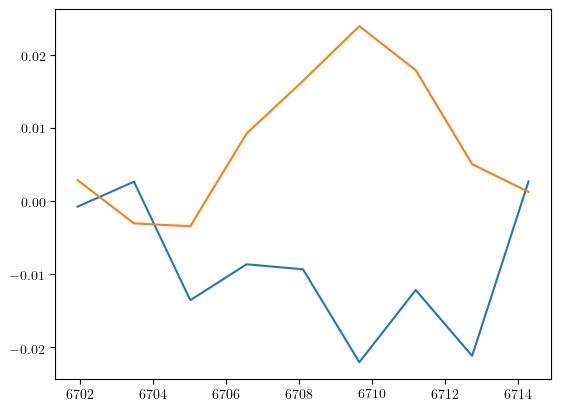

[154204108, 321609186, 156803144, 214008018, 173103134, 160114155]
[181709187, 291415040, 421404044, 274608148, 363911217, 387710043]
(6, 3559)


In [277]:
k, q = 6, 5

ind = rand(1:length(outlier_spectra))
f = test_spectra[ind]
ivar = test_ivar[ind]

neighbors = find_neighbors(f[.! line_mask], 
    ivar[.! line_mask].^(-5f-1), 
    rf_spectra[:, .! line_mask]', 
    rf_ivar[:, .! line_mask]'.^(-5f-1), k)
#dists = map(zip(eachrow(rf_spectra), eachrow(rf_ivar)) do (rf_spec, rfivar)
#    sum((f[.! line_mask] .- rf_spec[.! line_mask]).^2 .* ivar[.! line_mask])
#end 
println(rf_obsids[neighbors])
println(outliers.neighbors[ind])
F = rf_spectra[neighbors, :]
println(size(F))

pf = project_onto_local_manifold(F, f, ivar, line_mask, q)

w = calculate_weights(Matrix(F[:, .! line_mask]'), f[.! line_mask], ivar[.! line_mask].^(-5f-1))

figure()
plot(wl_grid[line_mask], F[:, line_mask]' * w - f[line_mask])
#plot(f[line_mask])
diff = eval(Meta.parse(outliers.diff[ind]))
plt.plot(wl_grid[line_mask], diff)

#println(outliers.diff[ind])
#ylim(-0.1, 0.1)
#yticks(-0.1 : 0.05 : 0.1)

#figure(figsize=(12, 4))
#plot(wl_grid, f, label = "data")
#plot(wl_grid, pf, label="projected spectrum")
#plot(wl_grid, F', c="k", alpha=0.1)
#axvline(6709.7)
#xlim(6670, 6750)
#axvspan(li_air-10, li_air+10, color="grey", alpha=0.3)
#ylim(0.9, 1.06)
#legend()
#
#figure(figsize=(12, 4))
#plot(wl_grid, f, label = "data")
#plot(wl_grid, pf, label="projected spectrum")
#plot(wl_grid, F', c="k", alpha=0.1)
#;